# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

* [1. Подготовка](#first_bullet)
    * [1.1. Импорт библиотек](#second_bullet)
    * [1.2. Чтение файла и изучение данных](#third_bullet)
    * [1.3. Анализ данных](#fourth_bullet)
* [2. Обучение](#fifth_bullet)
    * [2.1. LogisticRegression](#sixth_bullet)
    * [2.2. RandomForestClassifier](#seventh_bullet)
    * [2.3. DecisionTreeClassifier](#eighth_bullet)
* [3. Выводы](#ninth_bullet)
* [4. Доработка проекта](#tenth_bullet)

## Подготовка

###  Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)

**Библиотеки для визуализации данных:**

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'seaborn'

**Библиотеки для обработки текста:**

In [3]:
! pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import re
import nltk
from nltk.corpus import stopwords as stopwords_nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer 

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 366 kB 893 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**Машинное обучение:**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

###  Чтение файла и изучение данных

Выполним следующие шаги:
- прочитаем файл и сохраним данные в переменной `data`
- посмотрим общую информацию о датафрейме
- выведем на экран первые и последние 5 строк датафрейма.

In [7]:
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.info())
display(data.head())
display(data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

text  \
0  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27                                                                                                                                                                                                                                                                                                                                                                            
1  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.                                                                                                                                                                                                                                                                                                                                                                                                            
3  "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "   
4  You, sir, are my hero. Any chance you remember what page that's on?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

   toxic  
0  0      
1  0      
2  0      
3  0      
4  0

text  \
159566  ":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the ""most significant"" ones?   \n\n"   
159567  You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page.  128.61.19.93                                                                                                                                                                                                       
159568  Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.                                                                                                                                                                                                                         
159569  And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.                                                                                                                                                                                        
159570  "\nAnd ... I really don't think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "                                                                                                              

        toxic  
159566  0      
159567  0      
159568  0      
159569  0      
159570  0

Видим, что:
- датафрейм содержит 2 столбца и 159571 запись в каждом из них
- пропусков в данных нету
- для признака `text` необходимо провести предобработку, т.е., необходимо очистить комментарии от лишних слов, провести токенизацию (разбиение текста на токены, т.е., отдельные фразы, слова, символы) и лемматизацию текста (приведение слова к начальной форме или лемме).

###  Анализ данных

Более подробно исследуем целевой признак `toxic`. 

Посмотрим на соотношение нейтральных и токсичных комментариев.  

In [8]:
values = data['toxic'].value_counts()
values = values.to_frame().reset_index()
values.columns = ['Boolean', 'Count']
values['Percentage'] = data['toxic'].value_counts(normalize=True)
pd.DataFrame(values)

values['Category'] = values['Boolean'].apply(lambda x: 'Toxic' if x == True else 'Neutral')
values

Boolean   Count  Percentage Category
0  0        143346  0.898321    Neutral
1  1        16225   0.101679    Toxic

In [9]:
fig = make_subplots(rows = 1, cols = 2, 
                    specs = [[{"type": "bar"}, {"type": "pie"}]], 
                    subplot_titles = ('К-во комментариев по группам', 
                                      'Доля комментариев по группам'))

fig.add_trace(go.Bar(x = values['Category'], y = values['Count']), row = 1, col = 1)
fig.add_trace(go.Pie(values = values['Percentage'], labels = values['Category']), row = 1, col = 2)

fig.update_layout(height = 450, showlegend = False, title_text = 'Комментарии в зависимости от их тональности')
fig.show()

Видим, что почти 90% комментариев имеет нейтральную или позитивную тональность, а 10 - негативную. Т.е., каждый 10-й комментарий можно трактовать как токсичный. 

Перед тем, как перейти к обучению моделей, сделаем предобработку текста:
- очистим комментарии от лишних символов (скобки, кавычки, пробелы и т.д.)
- удалим стоп-слова
- сделаем лемматизацию слов и посмотрим, какие слова чаще всего используется в комментариях разной тональности.

Сначала создадим копию датафрейма.

In [13]:
df = data.copy()
df.shape

(159571, 2)

Уберем лишние символы и приведем текст в нижний регистр.  

In [14]:
def remove_punctuation(text):
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return clean_text

df['punctuation_free'] = df['text'].apply(lambda x: remove_punctuation(x.lower()))
df.head(3)

text  \
0  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27   
1  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)                                                                                                                                                            
2  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.                                   

   toxic  \
0  0       
1  0       
2  0       

                                                                                                                                                                                                                                                           punctuation_free  
0  explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now               
1  d aww  he matches this background colour i m seemingly stuck with  thanks    talk         january           utc                                                                                                                                                           
2  hey man  i m really not trying to edit war  it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page  he seems to care more about the formatting than the actual info

Удалим стоп-слова.

In [15]:
stop_words = set(stopwords_nltk.words('english'))  

def remove_stopwords(text):
    clean_text = [w for w in text.split() if not w in stop_words]  
    return clean_text

df['stopwords_free'] = df['punctuation_free'].apply(lambda x: remove_stopwords(x))
df.head(3)

text  \
0  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27   
1  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)                                                                                                                                                            
2  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.                                   

   toxic  \
0  0       
1  0       
2  0       

                                                                                                                                                                                                                                                           punctuation_free  \
0  explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now                
1  d aww  he matches this background colour i m seemingly stuck with  thanks    talk         january           utc                                                                                                                                                            
2  hey man  i m really not trying to edit war  it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page  he seems to care more about the formatting than the actual info                                   

                                                                                                                                                                           stopwords_free  
0  [explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]  
1  [aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]                                                                                                        
2  [hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]

Проведем лемматизацию слов.

In [16]:
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_text(text):
    clean_text = [lemmatizer.lemmatize(word) for word in text]
    return clean_text

df['lemmas'] = df['stopwords_free'].apply(lambda x: lemmatize_text(x))
df.head(3)

text  \
0  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27   
1  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)                                                                                                                                                            
2  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.                                   

   toxic  \
0  0       
1  0       
2  0       

                                                                                                                                                                                                                                                           punctuation_free  \
0  explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now                
1  d aww  he matches this background colour i m seemingly stuck with  thanks    talk         january           utc                                                                                                                                                            
2  hey man  i m really not trying to edit war  it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page  he seems to care more about the formatting than the actual info                                   

                                                                                                                                                                           stopwords_free  \
0  [explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]   
1  [aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]                                                                                                         
2  [hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]                      

                                                                                                                                                                                 lemmas  
0  [explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalism, closure, gas, voted, new, york, doll, fac, please, remove, template, talk, page, since, retired]  
1  [aww, match, background, colour, seemingly, stuck, thanks, talk, january, utc]                                                                                                        
2  [hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]

Отфильтруем комментарии в зависимости от того, какую тональность они имеют.

In [17]:
all_list = list(df['lemmas'])
comments_all = [item for sublist in all_list for item in sublist]

neutral = df.query('toxic == 0')
neutral_list = list(neutral['lemmas'])
comments_neutral = [item for sublist in neutral_list for item in sublist]

toxic = df.query('toxic == 1')
toxic_list = list(toxic['lemmas'])
comments_toxic = [item for sublist in toxic_list for item in sublist]

In [18]:
lists_of_comments_by_type = {'Все комментарии' : comments_all, 
                             'Нейтральные комментарии': comments_neutral, 
                             'Токсичные комментарии': comments_toxic}

Визуализируем результат. 

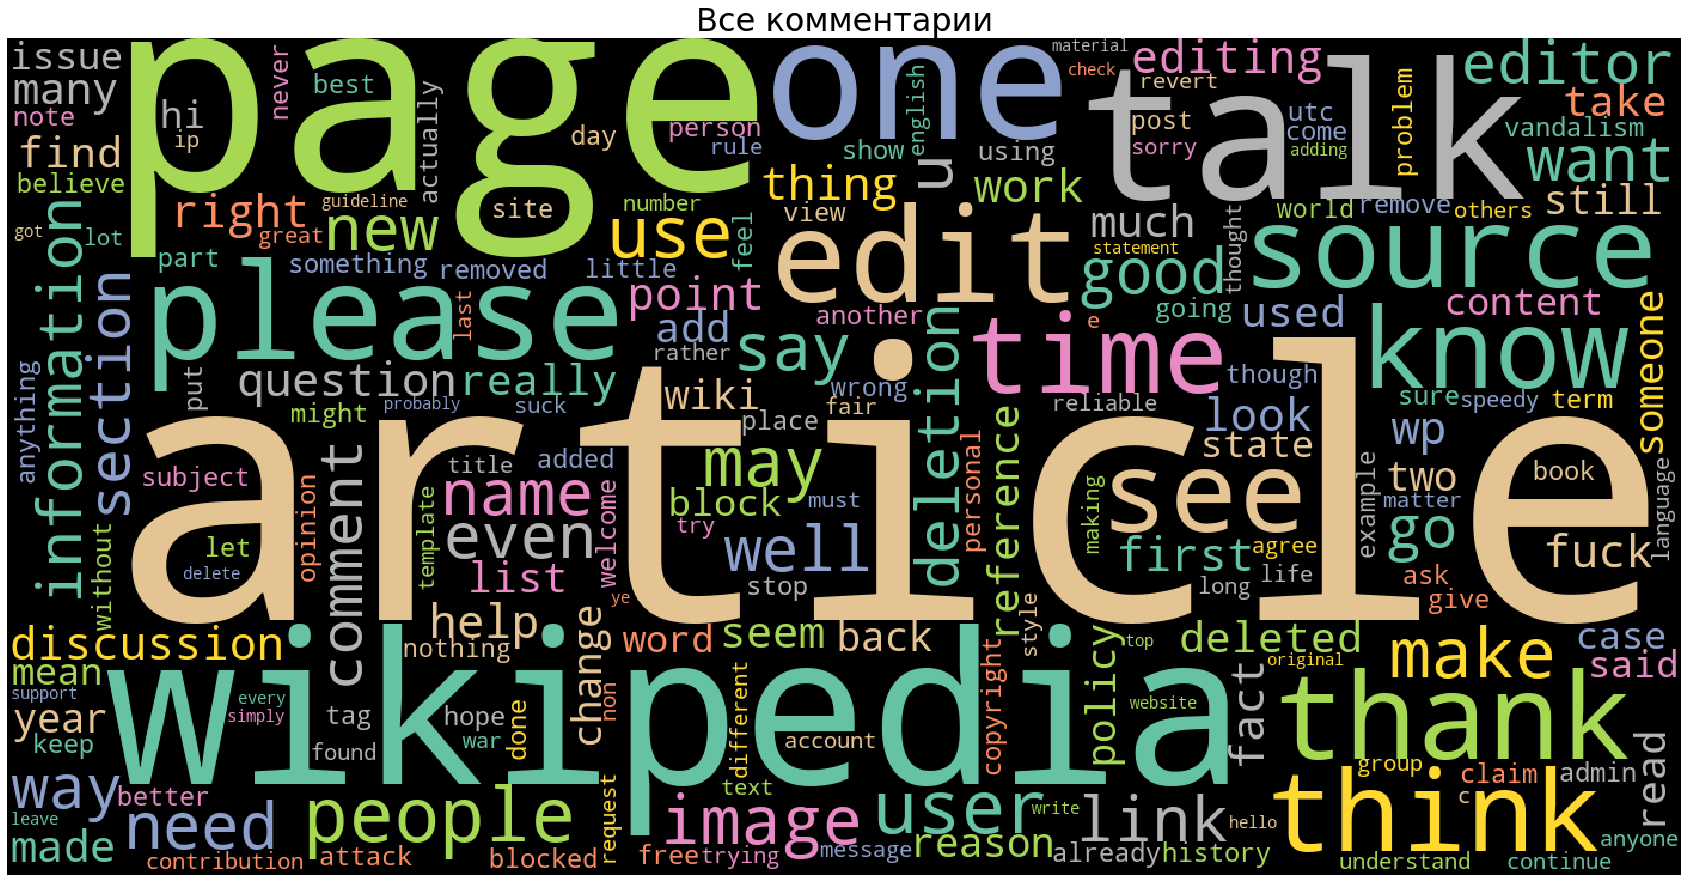

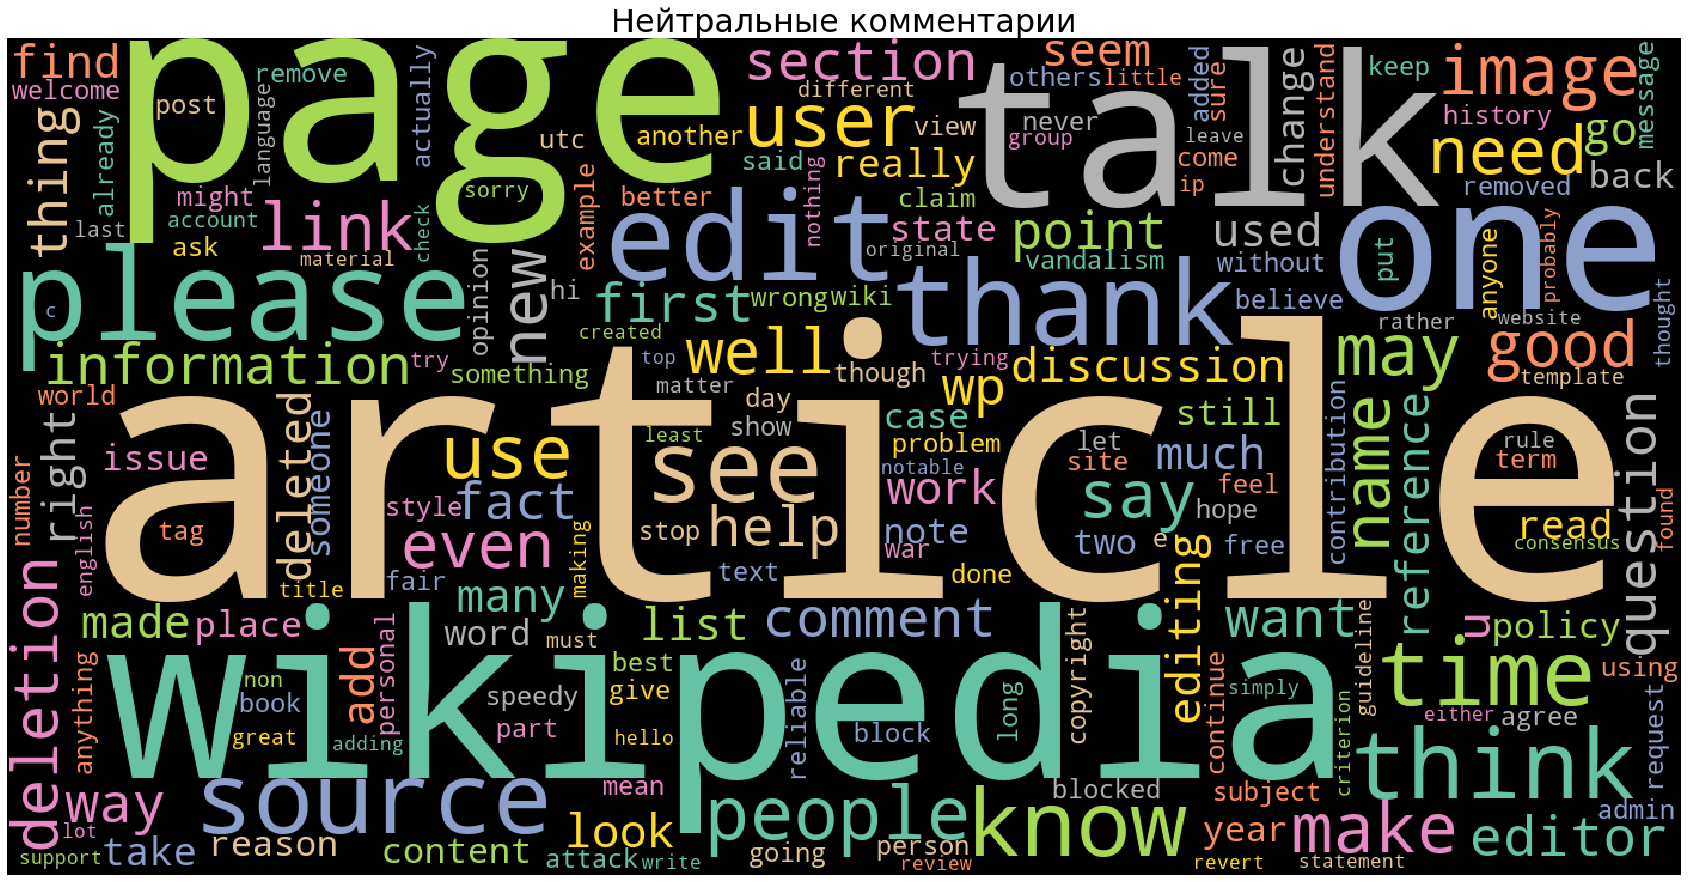

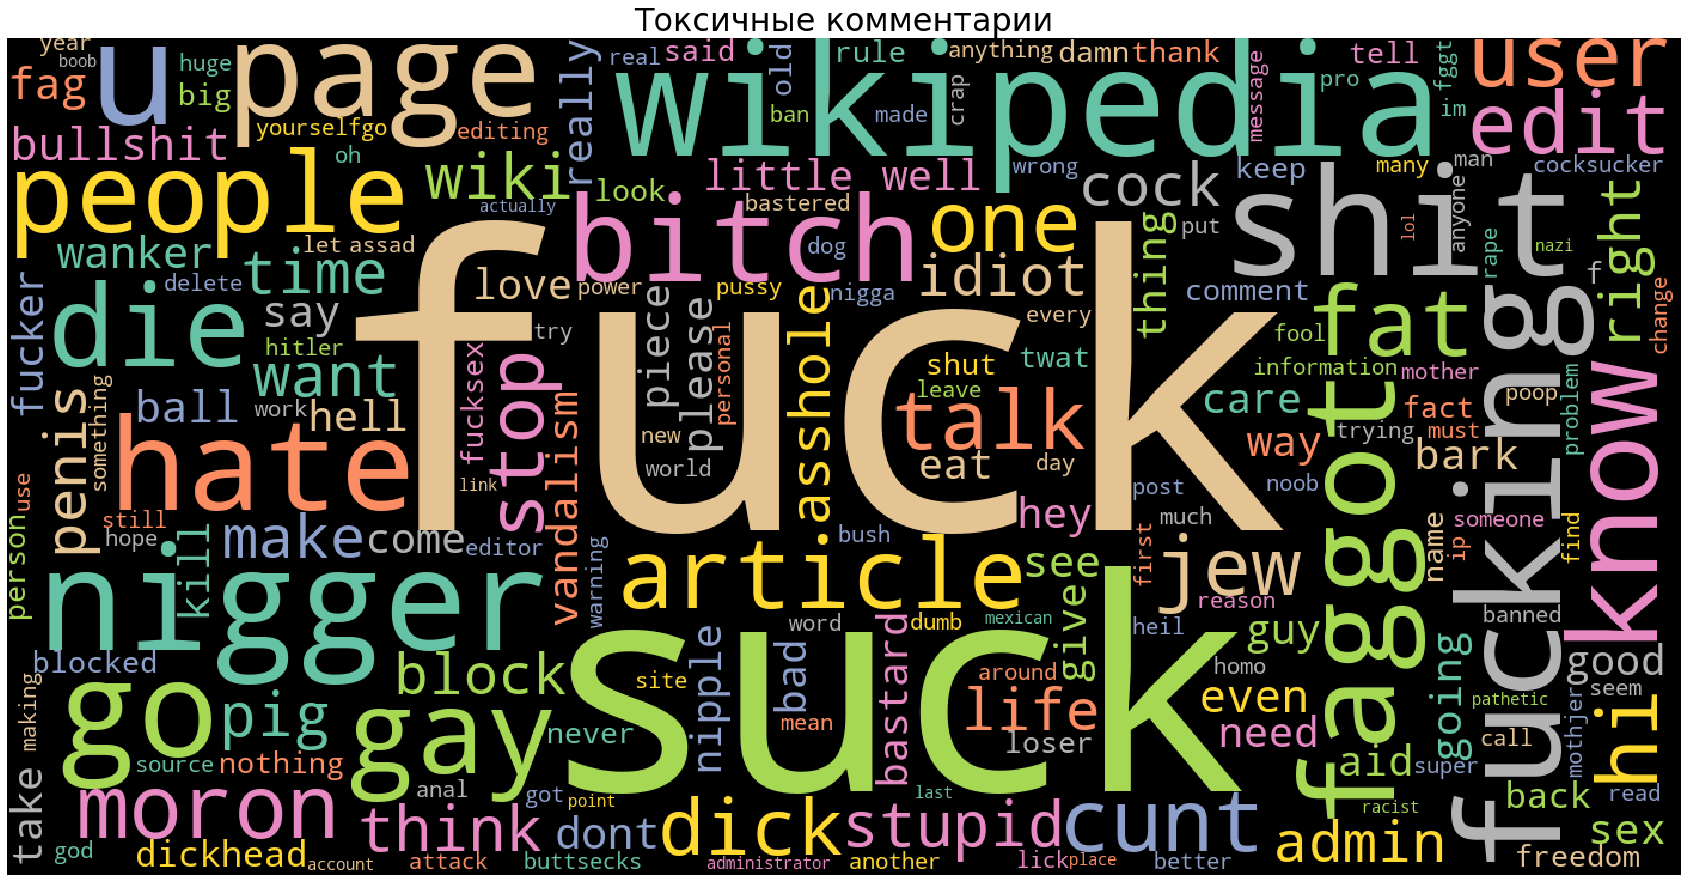

In [19]:
for key, value in lists_of_comments_by_type.items():
    
    wordcloud = WordCloud(random_state=123, 
                          width = 1400, 
                          height = 700,
                          background_color='black', 
                          colormap='Set2', 
                          collocations=False, 
                          stopwords = STOPWORDS).generate(' '.join(w for w in value))
    
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis('off')
    plt.title(key, fontsize=32)

Картинки выше наглядно отображают то, какие слова чаще всего используется в комментариях разной тональности. 

Подготовим очищенный набор данных для обучения моделей:
- выделим целевой признак `toxic` и признаки 

In [20]:
target = df['toxic']
features = df.drop('toxic', axis = 1)

print('Целевой признак:', target.shape)
print('Признаки:', features.shape)

Целевой признак: (159571,)
Признаки: (159571, 4)


- разделим датафрейм на обучающую и тестовую выборки в соотношении 80:20

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            train_size=0.80, 
                                                                            test_size=0.20, 
                                                                            random_state=123)

- посмотрим на размеры выборок

In [22]:
samples = {'Размер обучающей выборки' : features_train, 
          'Размер тестовой выборки': features_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (127656, 4)
Размер тестовой выборки: (31915, 4)


- признак `stopwords_free` в обучающей и в тестовой выборке приведем к типу `unicode

In [24]:
corpus_train = features_train['stopwords_free'].astype('U')
corpus_test = features_test['stopwords_free'].astype('U')
corpus_test[:3]

50446    ['redirect', 'names']                                                                                                                                                 
81571    ['sinebot', 'please', 'read', 'comments']                                                                                                                             
25983    ['thank', 'good', 'answer', 'realized', 'reading', 'question', 'stupid', 'probably', 'doublechecking', 'names', 'adding', 'appropriate', 'redirects', 'thank', 'work']
Name: stopwords_free, dtype: object

- вычислим `TF-IDF` для корпуса текстов

In [25]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit(corpus_train) 

In [26]:
train_X = tf_idf.transform(corpus_train)
test_X = tf_idf.transform(corpus_test)

## Обучение

Обучим следующие модели:
- LogisticRegression
- RandomForestClassifier
- DecisionTreeClassifier.

###  LogisticRegression

In [27]:
model = LogisticRegression(random_state=123, class_weight='balanced') 
model.fit(train_X, target_train)
predictions = model.predict(test_X)

f1 = f1_score(target_test, predictions)
print('LogisticRegression:', f1)

LogisticRegression: 0.7507632528448515


Видим, что модель `LogisticRegression` справилась с поставленной задачей и достигла показатель метрики качества `F1` не меньше `0.75`. 

Но ради эксперимента обучим другие модели и попробуем улучшить результат. 

###  RandomForestClassifier

In [28]:
model = RandomForestClassifier(random_state=123, class_weight = 'balanced') 
model.fit(train_X, target_train)
predictions = model.predict(test_X)

f1 = f1_score(target_test, predictions)
print('RandomForestClassifier', f1)

RandomForestClassifier 0.6197360150848523


Показатель метрики далеко от требуемого. Попробуем улучшить работу модели при помощи настройки гиперпараметров `depth` и `estimator`. 

In [29]:
%%time
results_rfc = []

for depth in range(1,11):
    
    for estimator in range(10, 51, 10):
        
        model = RandomForestClassifier(random_state=123, 
                                       class_weight = 'balanced', 
                                       n_estimators=estimator, 
                                       max_depth=depth) 
        
        model.fit(train_X, target_train)
        predictions = model.predict(test_X)

        f1 = f1_score(target_test, predictions)
        results_rfc.append({'Model': 'RandomForestClassifier', 
                            'Hyperparameters': {'random_state': 123, 
                                                'class_weight': 'balanced',
                                                'n_estimators': estimator, 
                                                'max_depth':depth}, 
                            'F1 score': f1})

CPU times: user 1min 17s, sys: 6.45 ms, total: 1min 17s
Wall time: 1min 20s


In [30]:
pd.DataFrame(results_rfc).style.highlight_max(color = 'lightgreen', axis = 0)

Модель стала работать значительно хуже. 

Посмотрим, какой результат покажет модель `DecisionTreeClassifier`.   

### DecisionTreeClassifier

In [31]:
model = DecisionTreeClassifier(random_state=123, class_weight = 'balanced')
model.fit(train_X, target_train)
predictions = model.predict(test_X)

f1 = f1_score(target_test, predictions)
print('DecisionTreeClassifier', f1)

DecisionTreeClassifier 0.6453870922581548


Гипперпараметры

In [32]:
results_dtc = []

for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=123, max_depth=depth, class_weight = 'balanced')
    model.fit(train_X, target_train)
    predictions = model.predict(test_X)

    f1 = f1_score(target_test, predictions)

    results_dtc.append({'Model': 'DecisionTreeClassifier', 
                        'Hyperparameters': {'random_state': 123, 
                                            'class_weight': 'balanced', 
                                            'max_depth': depth},
                        'F1 score': f1})

In [33]:
pd.DataFrame(results_dtc).style.highlight_max(color = 'lightgreen', axis = 0)

## Выводы


Во время проекта:

1) изучили и подготовили данные:

посмотрели общую информацию о данных
убедились, что пропуски отсутствуют
провели предобработку текста (удалили лишние символы, убрали стоп-слова)
сделали визуализацию, которая показывает какие слова чаще всего встречаются в комментариях разной тональности.

2) обучили следующие модели: LogisticRegression, RandomForestClassifier и DecisionTreeClassifier. Только модель LogisticRegression справилась с поставленной задачей - достичь метрику качества F1 не меньше 0.75.

Интересно, что такие модели как RandomForestClassifier и DecisionTreeClassifier в этой задаче показали гораздo хуже результат нежели LogisticRegression. К тому же, настройка гиперпараметров значительно ухудшила работу этих моделей. Также стоит отметить, что эти модели обучаются гораздо дольше чем модель LogisticRegression.

Результат: как наилучшую модель для классификации комментариев можно рекомендовать модель LogisticRegression с гиперпараметром class_weight = 'balanced', которая дает результат F1 = 0.751.